# Klassifikation
I dette afsnit vil vi lave klassifikationstræ af wineQT-datasættet og beskære dem. Vi bruger to forskellige kriterier Entropy og Giniindex, der begge  er et mål for knuderenhed, altså i hvor høj grad knuden kun indeholder de data med den label, som knuden klassificerer til. Vi har valgt at bruge disse kriterier, da de er sensitive overfor trægroning.


Vi vil lave et klassifikationstræ af wineQT datasettet. Vi starter med at importere det nødvendige og indlæser datasettet.

Vi importerer de nødvendige pakker.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import  confusion_table
from ISLP.models import ModelSpec as MS

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR,plot_tree ,export_text)
from sklearn.metrics import (accuracy_score ,log_loss)

Vi indlæser data.

In [3]:
df = pd.read_csv("WineQT.csv")

Vi bruger nu DecisionTreeClassifier() til at lave et klassifikationstræ for at forudsige vinkvaliteten ved hjælp af alle variable undtagen 'quality'. For at gøre dette danner vi en modelmatrix.

In [13]:
model = MS(df.columns.drop('quality'), intercept=False)

D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)
y = np.asarray(df['quality'])
print(type(y))

<class 'numpy.ndarray'>


# Klassifikationstræ med Entropy
Vi har omdannet D fra en dataframe til et array X. Dette er nødvendigt i nogle af de nedenstående analyser. Vi har også brug for feature_names til at annotere vores plots senere.
Vi vælger max_depth til 3.Vi bruger entropy givet ved  
$D=-\sum_{k=1}^K\hat{p}_{mk}\log \hat{p}_{mk}$ i første omgang.

In [14]:
clf = DTC(criterion='entropy', max_depth=3,random_state=0)
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [15]:
accuracy_score(y, clf.predict(X))

0.5931758530183727

In [16]:
resid_dev = np.sum(log_loss(y, clf.predict_proba(X)))
resid_dev

0.9473115270480177

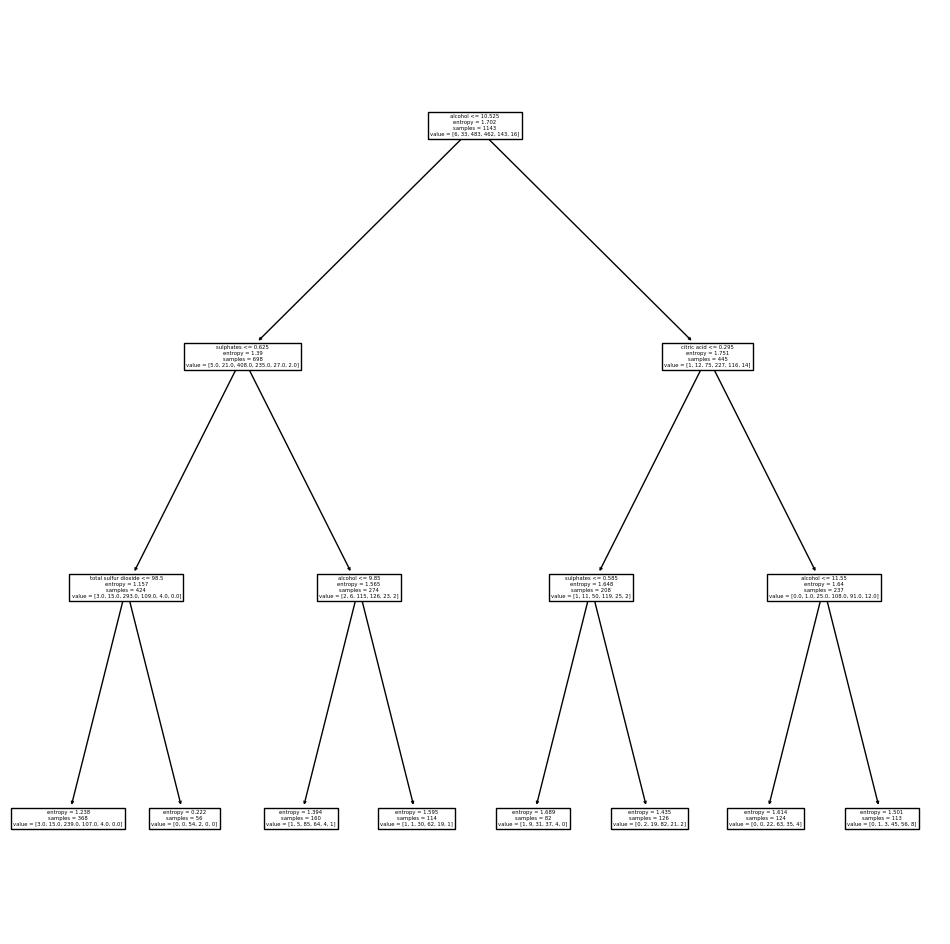

In [17]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,feature_names=feature_names, ax=ax);

Vi ser at den vigtigeste variable er alcoholprocenten.

In [18]:
print(export_text(clf, feature_names = feature_names, show_weights = True))

|--- alcohol <= 10.53
|   |--- sulphates <= 0.62
|   |   |--- total sulfur dioxide <= 98.50
|   |   |   |--- weights: [3.00, 15.00, 239.00, 107.00, 4.00, 0.00] class: 5
|   |   |--- total sulfur dioxide >  98.50
|   |   |   |--- weights: [0.00, 0.00, 54.00, 2.00, 0.00, 0.00] class: 5
|   |--- sulphates >  0.62
|   |   |--- alcohol <= 9.85
|   |   |   |--- weights: [1.00, 5.00, 85.00, 64.00, 4.00, 1.00] class: 5
|   |   |--- alcohol >  9.85
|   |   |   |--- weights: [1.00, 1.00, 30.00, 62.00, 19.00, 1.00] class: 6
|--- alcohol >  10.53
|   |--- citric acid <= 0.30
|   |   |--- sulphates <= 0.58
|   |   |   |--- weights: [1.00, 9.00, 31.00, 37.00, 4.00, 0.00] class: 6
|   |   |--- sulphates >  0.58
|   |   |   |--- weights: [0.00, 2.00, 19.00, 82.00, 21.00, 2.00] class: 6
|   |--- citric acid >  0.30
|   |   |--- alcohol <= 11.55
|   |   |   |--- weights: [0.00, 0.00, 22.00, 63.00, 35.00, 4.00] class: 6
|   |   |--- alcohol >  11.55
|   |   |   |--- weights: [0.00, 1.00, 3.00, 45.00, 56.

I de kantede parenteser kan man se hvor mange der er fra hver kategori i det pågældende blad. Fx [0.00, 2.00, 19.00, 82.00, 21.00, 2.00] class: 6
betyder at der er ingen med label 3, 2 med label 4, 19 med label 5, 82 med label 6, 21 med label 7 og 2 med label 8 i dette blad der klassificerer til label 6.

Vi beregner testscoren. Dette tal siger at modellen ramte rigtig i 62% af tilfældene.

In [21]:
validation = skm.ShuffleSplit(n_splits=5, test_size=200,random_state=0)
results = skm.cross_validate(clf,D,y,cv = validation)
results['test_score']

array([0.62 , 0.58 , 0.59 , 0.615, 0.54 ])

Nu skal træet beskæres (prunning). Først deles op i test og trænningssæt. Vi bruger crossvalidation til at beskære træet i trænningssættet og evaluere performance på det beskærede træ i testsættet.

In [22]:
(X_train,
 X_test ,
 y_train ,
 y_test) = skm.train_test_split(X,y , test_size=0.5, random_state=0)

Vi genfitter træet på testsættet. Her sætter vi ikke nogen maxdybde, da vi vil se hvad beskæringen giver os.

In [23]:
clf = DTC(criterion='entropy', random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.5384615384615384

In [24]:
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,random_state=1, shuffle=True)

In [25]:
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.5535390199637023

Dette er scoren 55.3% for det ubeskårede træ. Den skal sammenlignes med den for det træ vi beskærer.

Vi kigger på det beskårede træ.



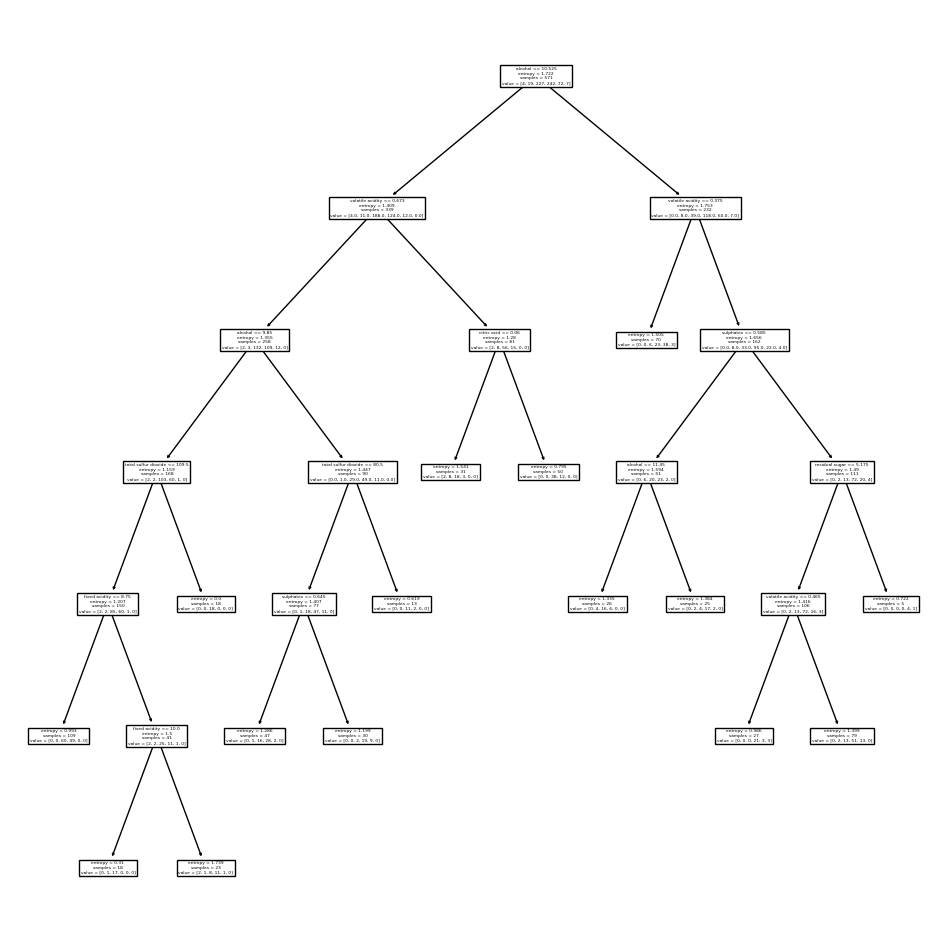

In [26]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,feature_names=feature_names, ax=ax);


In [27]:
print(export_text(best_, feature_names = feature_names, show_weights = True))

|--- alcohol <= 10.53
|   |--- volatile acidity <= 0.67
|   |   |--- alcohol <= 9.85
|   |   |   |--- total sulfur dioxide <= 109.50
|   |   |   |   |--- fixed acidity <= 8.75
|   |   |   |   |   |--- weights: [0.00, 0.00, 60.00, 49.00, 0.00, 0.00] class: 5
|   |   |   |   |--- fixed acidity >  8.75
|   |   |   |   |   |--- fixed acidity <= 10.00
|   |   |   |   |   |   |--- weights: [0.00, 1.00, 17.00, 0.00, 0.00, 0.00] class: 5
|   |   |   |   |   |--- fixed acidity >  10.00
|   |   |   |   |   |   |--- weights: [2.00, 1.00, 8.00, 11.00, 1.00, 0.00] class: 6
|   |   |   |--- total sulfur dioxide >  109.50
|   |   |   |   |--- weights: [0.00, 0.00, 18.00, 0.00, 0.00, 0.00] class: 5
|   |   |--- alcohol >  9.85
|   |   |   |--- total sulfur dioxide <= 80.50
|   |   |   |   |--- sulphates <= 0.64
|   |   |   |   |   |--- weights: [0.00, 1.00, 16.00, 28.00, 2.00, 0.00] class: 6
|   |   |   |   |--- sulphates >  0.64
|   |   |   |   |   |--- weights: [0.00, 0.00, 2.00, 19.00, 9.00, 0.00] 

In [28]:
best_.tree_.n_leaves

15

Dette betyder at træet med 15 blade giver den laveste crossvalidation fejl. Dette var træningssættet.

Nu vil vi se hvor godt det beskærede træ er på test-sættet. Vi anvender predict() og beregner konfusionmatricen.

In [29]:
print(accuracy_score(y_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),y_test)
confusion

0.6013986013986014


Truth,3,4,5,6,7,8
Predicted,,,,,,
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,2,10,190,64,4,0
6,0,4,58,122,35,5
7,0,0,8,34,32,4
8,0,0,0,0,0,0


Men det ses at scoren for beskårede træ 60.1% er noget bedre ved det beskårede træ end ved det oprindelige træ hvor den bar 55.3%
Den er også bedre end de 57.3 % ved logistisk regression, som vi lavede i aflevering 2

Nu vil vi prøve med Gini istedet for Entropy. Giniindexet er givet ved
$G=\sum_{k=1}^K\hat{p}_{mk}(1-\hat{p}_{mk})$

In [35]:
clf_gini = DTC(criterion='gini', max_depth=3,random_state=0)
clf_gini.fit(X, y)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [36]:
accuracy_score(y, clf_gini.predict(X))

0.6010498687664042

In [37]:
resid_dev = np.sum(log_loss(y, clf_gini.predict_proba(X)))
resid_dev

0.9457540448176145

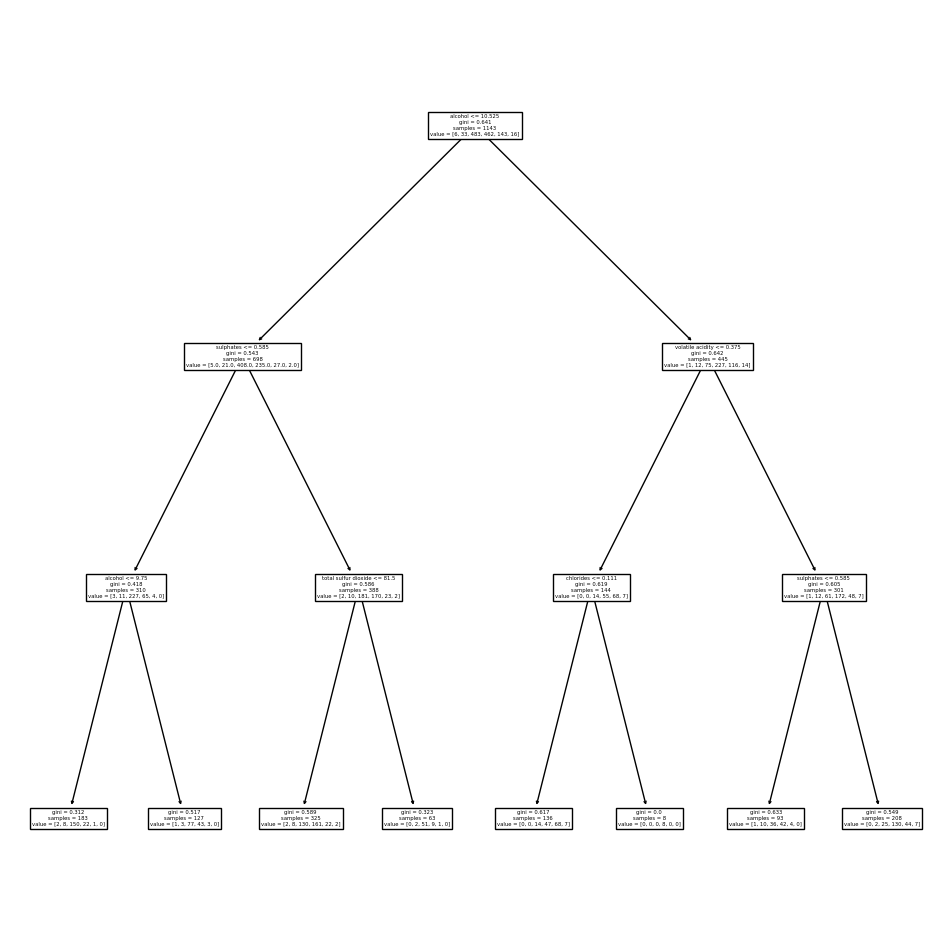

In [38]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf_gini,feature_names=feature_names, ax=ax);

In [39]:
print(export_text(clf_gini, feature_names = feature_names, show_weights = True))

|--- alcohol <= 10.53
|   |--- sulphates <= 0.58
|   |   |--- alcohol <= 9.75
|   |   |   |--- weights: [2.00, 8.00, 150.00, 22.00, 1.00, 0.00] class: 5
|   |   |--- alcohol >  9.75
|   |   |   |--- weights: [1.00, 3.00, 77.00, 43.00, 3.00, 0.00] class: 5
|   |--- sulphates >  0.58
|   |   |--- total sulfur dioxide <= 81.50
|   |   |   |--- weights: [2.00, 8.00, 130.00, 161.00, 22.00, 2.00] class: 6
|   |   |--- total sulfur dioxide >  81.50
|   |   |   |--- weights: [0.00, 2.00, 51.00, 9.00, 1.00, 0.00] class: 5
|--- alcohol >  10.53
|   |--- volatile acidity <= 0.38
|   |   |--- chlorides <= 0.11
|   |   |   |--- weights: [0.00, 0.00, 14.00, 47.00, 68.00, 7.00] class: 7
|   |   |--- chlorides >  0.11
|   |   |   |--- weights: [0.00, 0.00, 0.00, 8.00, 0.00, 0.00] class: 6
|   |--- volatile acidity >  0.38
|   |   |--- sulphates <= 0.58
|   |   |   |--- weights: [1.00, 10.00, 36.00, 42.00, 4.00, 0.00] class: 6
|   |   |--- sulphates >  0.58
|   |   |   |--- weights: [0.00, 2.00, 25.00,

In [41]:
validation = skm.ShuffleSplit(n_splits=5, test_size=200,random_state=0)
results = skm.cross_validate(clf_gini,D,y,cv = validation)
results['test_score']

array([0.54 , 0.58 , 0.585, 0.61 , 0.545])

In [26]:
clf_gini = DTC(criterion='gini', random_state=0)
clf_gini.fit(X_train, y_train)
accuracy_score(y_test, clf_gini.predict(X_test))

0.5454545454545454

In [27]:
ccp_path = clf_gini.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,random_state=1, shuffle=True)

In [28]:
grid = skm.GridSearchCV(clf_gini,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.5621899576527526

Dette er scoren 56.2% for det ubeskårede træ. Den skal sammenlignes med den for det træ vi beskærer.

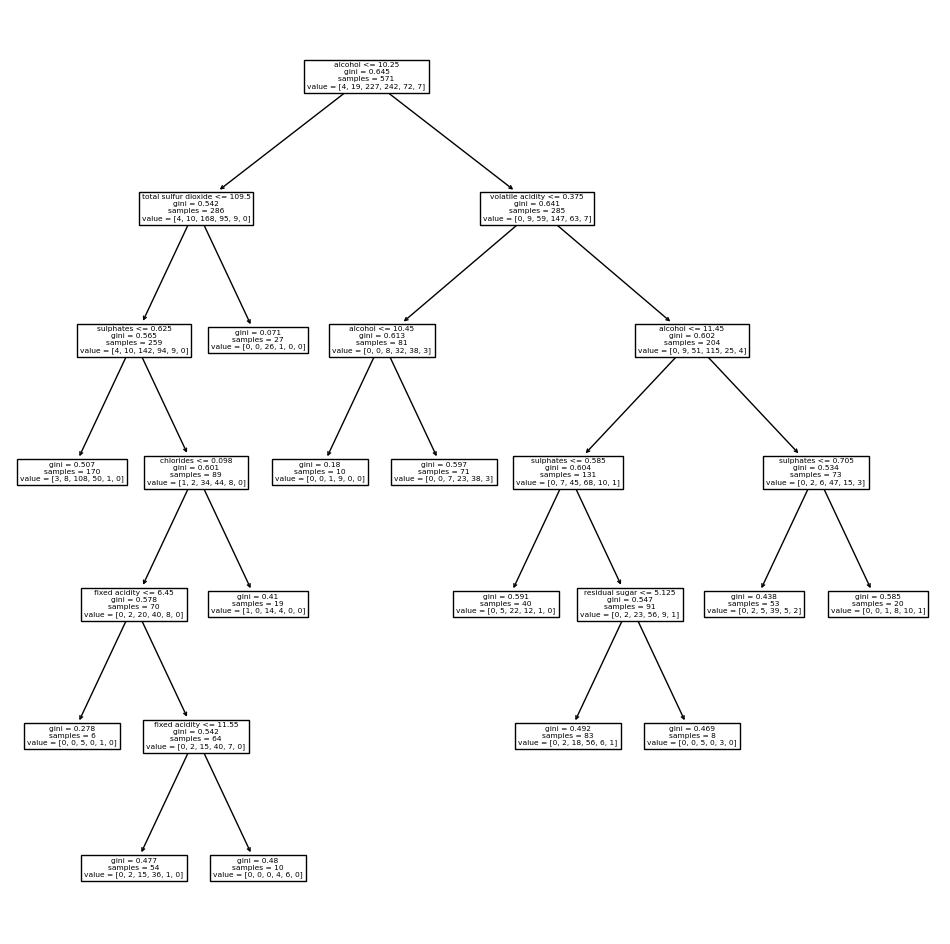

In [29]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,feature_names=feature_names, ax=ax);


In [30]:
print(export_text(best_, feature_names = feature_names, show_weights = True))

|--- alcohol <= 10.25
|   |--- total sulfur dioxide <= 109.50
|   |   |--- sulphates <= 0.62
|   |   |   |--- weights: [3.00, 8.00, 108.00, 50.00, 1.00, 0.00] class: 5
|   |   |--- sulphates >  0.62
|   |   |   |--- chlorides <= 0.10
|   |   |   |   |--- fixed acidity <= 6.45
|   |   |   |   |   |--- weights: [0.00, 0.00, 5.00, 0.00, 1.00, 0.00] class: 5
|   |   |   |   |--- fixed acidity >  6.45
|   |   |   |   |   |--- fixed acidity <= 11.55
|   |   |   |   |   |   |--- weights: [0.00, 2.00, 15.00, 36.00, 1.00, 0.00] class: 6
|   |   |   |   |   |--- fixed acidity >  11.55
|   |   |   |   |   |   |--- weights: [0.00, 0.00, 0.00, 4.00, 6.00, 0.00] class: 7
|   |   |   |--- chlorides >  0.10
|   |   |   |   |--- weights: [1.00, 0.00, 14.00, 4.00, 0.00, 0.00] class: 5
|   |--- total sulfur dioxide >  109.50
|   |   |--- weights: [0.00, 0.00, 26.00, 1.00, 0.00, 0.00] class: 5
|--- alcohol >  10.25
|   |--- volatile acidity <= 0.38
|   |   |--- alcohol <= 10.45
|   |   |   |--- weights: [

In [31]:
best_.tree_.n_leaves

13

Det ses at vi her har kun 13 blade mod 15, da vi brugte Entropy. Vi få altså her et mindre træ.

In [32]:
print(accuracy_score(y_test, best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),y_test)
confusion

0.6066433566433567


Truth,3,4,5,6,7,8
Predicted,,,,,,
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,1,12,193,69,6,0
6,1,2,51,105,16,2
7,0,0,12,46,49,7
8,0,0,0,0,0,0


# Delkonklusion
Her er scoren for beskårede træ 60.7% er noget bedre ved det beskårede træ end ved det oprindelige træ hvor den var 56.7%

Vi får altså den bedste score ved at bruge Giniindexet, og da træ med entropy der beskæres var bedre en ved logistisk regression, så er dette træ med Gini, beskåret endnu bedre.